## Fraud Detection: Data Preparation
**Exploratory Data Analysis, Feature Engineering**

Predict the probability that an online transaction is fraudulent, as denoted by the binary target isFraud. Data set: https://www.kaggle.com/c/ieee-fraud-detection/overview

The data is broken into two files, identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information. Data description discussion: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-625700

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats.stats import ttest_ind

import re

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load train data:
df_train_identity = pd.read_csv('train_identity.csv')
df_train_transaction = pd.read_csv('train_transaction.csv')

In [3]:
df_train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# join transaction and identity train data:
df_train = pd.merge(df_train_transaction, df_train_identity,
                    how='left', on='TransactionID')
print(df_train.shape)

(590540, 434)


In [6]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
del df_train_identity, df_train_transaction

In [8]:
# # get percentage of missing values:
# df_null = (df_train.isnull().sum()*100/df_train.isnull().count())
# df_null.sort_values(ascending=False)

In [9]:
# drop variables with over 80% of missing values:
df_train.dropna(thresh=df_train.shape[0]*0.20,
                how='all',axis=1,inplace=True)
df_train.shape

(590540, 360)

In [10]:
df_train = df_train.drop('TransactionID',axis=1)

In [11]:
encode = LabelEncoder()

# impute missing data:
for i in df_train.columns:
    if df_train[i].dtype==object:
        df_train[i] = df_train[i].fillna('missing')
        #df_train[i] = encode.fit_transform(df_train[i])
    else:
        df_train[i].fillna(df_train[i].mean(),inplace=True)

In [12]:
# df_train.columns

In [13]:
df_train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,362.555488,150.0,discover,142.0,credit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
1,0,86401,29.0,W,2755,404.000000,150.0,mastercard,102.0,credit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,0,86469,59.0,W,4663,490.000000,150.0,visa,166.0,debit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
3,0,86499,50.0,W,18132,567.000000,150.0,mastercard,117.0,debit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
4,0,86506,50.0,H,4497,514.000000,150.0,mastercard,102.0,credit,...,144.000000,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### isFraud -- target variable

Text(0.5, 1.0, 'Distribution of Normal vs Fraudelent Transactions')

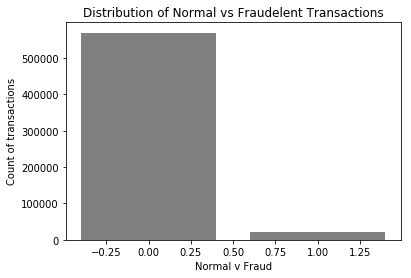

In [14]:
# plot normal vs fraudelent transactions:
plt.bar(df_train.groupby('isFraud')['isFraud'].count().index,
         df_train.groupby('isFraud')['isFraud'].count(), color='grey')
plt.ylabel('Count of transactions')
plt.xlabel('Normal v Fraud')
plt.title('Distribution of Normal vs Fraudelent Transactions')

In [15]:
print(df_train['isFraud'].value_counts())
df_train['isFraud'].value_counts()[1]*100/df_train['isFraud'].value_counts()[0]

0    569877
1     20663
Name: isFraud, dtype: int64


3.625870143908247

**Class Imbalance**: 
Only 3.6% of all observations are labeled as fraud. We'll address class imbalance during the modeling stage.

## TransactionDT
"timedelta from a given reference datetime (not an actual timestamp)"

In [16]:
df_train['TransactionDT'].unique()

array([   86400,    86401,    86469, ..., 15811079, 15811088, 15811131])

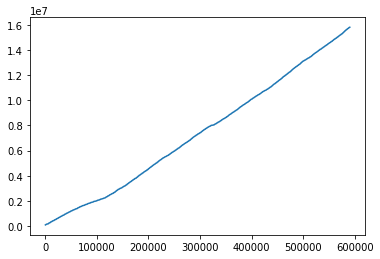

In [20]:
plt.plot(df_train['TransactionDT'])

## TransactionAmt
"transaction payment amount in USD"

Text(0.5, 0, 'Transactions')

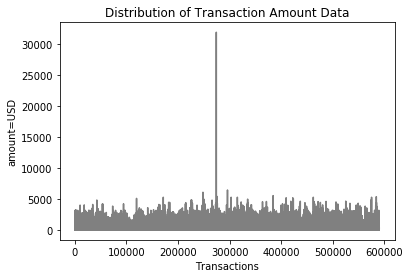

In [21]:
# plot transaction amount data:
plt.plot(df_train['TransactionAmt'], color='grey')
plt.title('Distribution of Transaction Amount Data')
plt.ylabel('amount=USD')
plt.xlabel('Transactions')

We have a few outliers that are interesting in fraud detection. For the purposes of supervised machine learning models, we'll winsorize the data to get rid of outliers.

Text(0.5, 1.0, 'Mean Transactions Labeled as Normal vs Fraud')

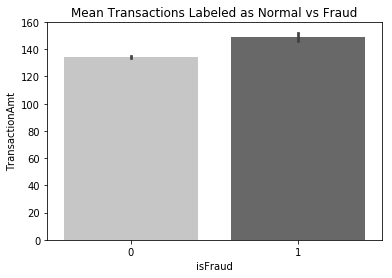

In [22]:
# plot normal vs. fraudelent transactions:
sns.barplot(df_train['isFraud'], df_train['TransactionAmt'], palette='Greys')
plt.title('Mean Transactions Labeled as Normal vs Fraud')

In [23]:
# get mean transaction amount for normal and fraudulent transactions:
df_train[['TransactionAmt','isFraud']].groupby('isFraud').mean()

,TransactionAmt
isFraud,
0,134.511665
1,149.244779


We observe that mean fraudelent transaction amounts are higher than mean normal: 149.2 USD vs. under 134.5 USD. Let's see if these differences are statistically significant.

In [24]:
# test whether group differences are significant:
ttest_ind(df_train[df_train.isFraud == 0][['TransactionAmt']],
          df_train[df_train.isFraud == 1][['TransactionAmt']])

Ttest_indResult(statistic=array([-8.6994436]), pvalue=array([3.34346246e-18]))

In [25]:
df_train.loc[df_train['TransactionAmt'] > 5000]

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
119566,0,2330164,5094.950,W,6019,583.0,150.0,visa,226.0,credit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
171451,0,3704698,5278.950,W,9500,321.0,150.0,visa,226.0,debit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
248413,0,5926506,6085.230,W,2755,404.0,150.0,mastercard,102.0,credit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
274336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,credit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
274339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,credit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
275529,0,6706260,5420.000,W,5033,269.0,150.0,mastercard,224.0,debit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
275535,0,6706356,5420.000,W,5033,269.0,150.0,mastercard,224.0,debit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
296021,0,7320188,6450.970,W,16661,490.0,150.0,visa,226.0,debit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
303106,0,7501413,5279.950,W,12583,404.0,150.0,mastercard,102.0,credit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing
315172,0,7850500,5279.950,W,11106,100.0,150.0,visa,226.0,credit,...,403.882666,missing,missing,missing,missing,missing,missing,missing,missing,missing


In [26]:
# winsorize transaction amount data:
df_train['TransactionAmt'] = winsorize(df_train['TransactionAmt'], (0, 0.05))

In [27]:
# get mean transaction amount for normal and fraudulent transactions:
df_train[['TransactionAmt','isFraud']].groupby('isFraud').mean()

,TransactionAmt
isFraud,
0,112.386970
1,124.980501


Text(0.5, 1.0, 'Boxplot of TransactionAmt')

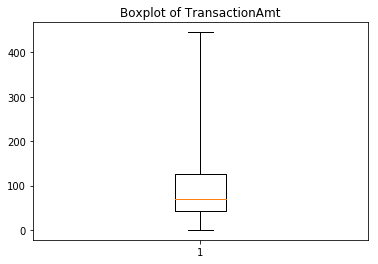

In [28]:
# plot to review if there are outliers:
plt.boxplot(df_train['TransactionAmt'], whis=10)
plt.title('Boxplot of TransactionAmt')

In [30]:
# confirm there are no outliers:
q75, q25 = np.percentile(df_train['TransactionAmt'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df_train['TransactionAmt'] > max_val) 
                      | (df_train['TransactionAmt'] < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 91539
The score threshold is: 1.5
Number of outliers is: 66482
The score threshold is: 2.0
Number of outliers is: 55384
The score threshold is: 2.5
Number of outliers is: 45084
The score threshold is: 3.0
Number of outliers is: 36422
The score threshold is: 3.5
Number of outliers is: 32455
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


## ProductCD
"product code, the product for each transaction"

In [31]:
df_train['ProductCD'].unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

In [32]:
# review number of normal vs fraudelent transaction based on product code 
count_table = pd.crosstab(df_train['isFraud'], df_train['ProductCD'])
print(count_table)

ProductCD      C      H      R      S       W
isFraud                                      
0          60511  31450  36273  10942  430701
1           8008   1574   1426    686    8969


Text(0.5, 1.0, 'Normal vs Fraud per Product Code')

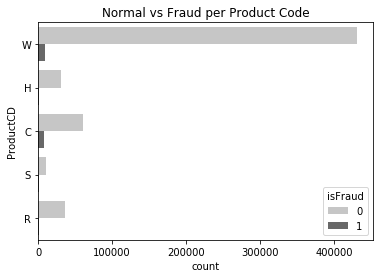

In [33]:
# plot counts:
sns.countplot(y=df_train['ProductCD'], hue=df_train['isFraud'], palette='Greys')
plt.title('Normal vs Fraud per Product Code')

In [34]:
# test if differences are statistically significant:
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=2656302.643817523, pvalue=0.0)


In [35]:
# label encode the variable:
encode = LabelEncoder()
df_train['ProductCD'] = encode.fit_transform(df_train['ProductCD'])

## card1 - card6

"card1 - card6: payment card information, such as card type, card category, issue bank, country, etc"

In [36]:
# for i in df_train.columns:
#     if i.startswith('card'):
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

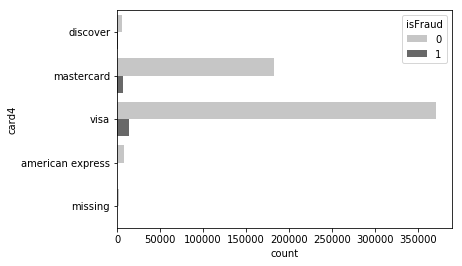

In [37]:
# plot card4
sns.countplot(y=df_train['card4'], hue=df_train['isFraud'], palette='Greys')

In [38]:
count_table = pd.crosstab(df_train['card4'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=2316075.626477461, pvalue=0.0)


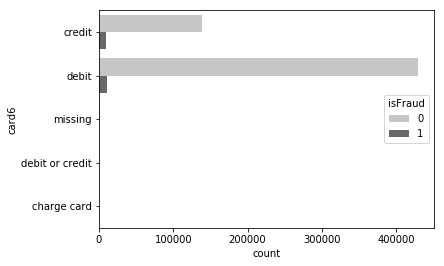

In [39]:
# plot card6
sns.countplot(y=df_train['card6'], hue=df_train['isFraud'], palette='Greys')

In [40]:
count_table = pd.crosstab(df_train['card6'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=2860773.6694889423, pvalue=0.0)


(array([3.01650e+04, 3.72650e+04, 3.30090e+04, 3.05900e+03, 6.17330e+04,
        1.35000e+02, 1.87570e+04, 1.41300e+04, 1.11110e+04, 3.81176e+05]),
 array([100. , 113.7, 127.4, 141.1, 154.8, 168.5, 182.2, 195.9, 209.6,
        223.3, 237. ]),
 <a list of 10 Patch objects>)

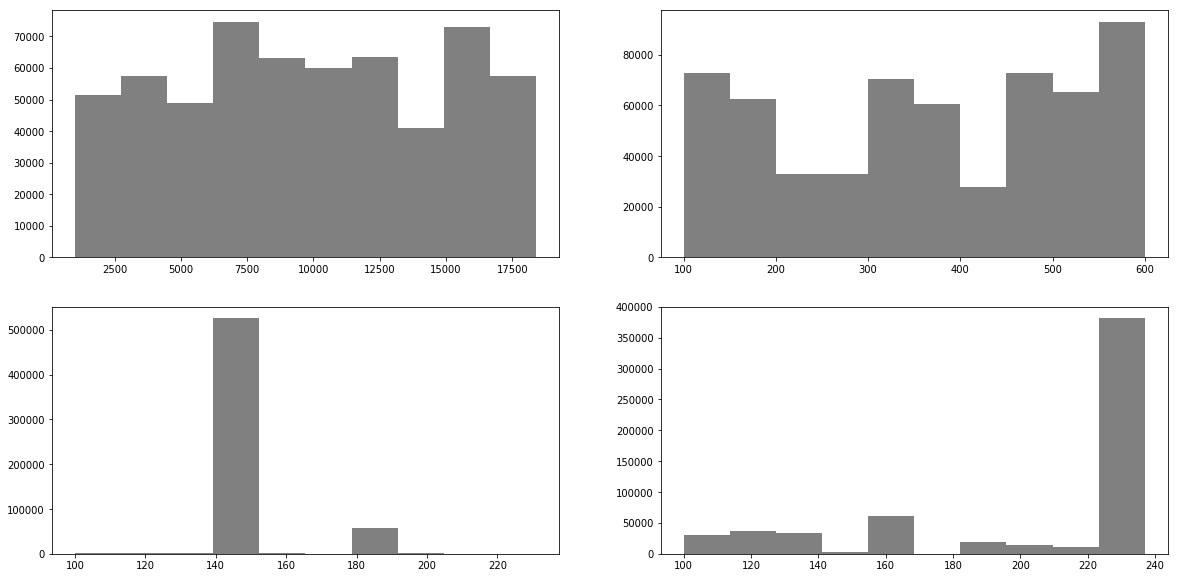

In [41]:
# plot the remaining card variables
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.hist(df_train['card1'], color='grey')
plt.subplot(2,2,2)
plt.hist(df_train['card2'], color='grey')
plt.subplot(2,2,3)
plt.hist(df_train['card3'], color='grey')
plt.subplot(2,2,4)
plt.hist(df_train['card5'], color='grey')

In [42]:
# encode variables: 
df_train['card4'] = encode.fit_transform(df_train['card4'])
df_train['card6'] = encode.fit_transform(df_train['card6'])

## addr

addr: address

In [43]:
# for i in df_train.columns:
#     if i.startswith('addr'):
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

In [44]:
df_train[['addr1','isFraud']].groupby('isFraud').mean()

ttest_ind(df_train[df_train.isFraud == 0][['addr1']],
          df_train[df_train.isFraud == 1][['addr1']])

Ttest_indResult(statistic=array([-3.41882181]), pvalue=array([0.00062897]))

In [45]:
df_train[['addr2','isFraud']].groupby('isFraud').mean()

ttest_ind(df_train[df_train.isFraud == 0][['addr2']],
          df_train[df_train.isFraud == 1][['addr2']])

Ttest_indResult(statistic=array([18.57075592]), pvalue=array([5.82948834e-77]))

## dist1
"distance"

In [46]:
for i in df_train.columns:
    if i.startswith('dist'):
        #print(i)
        print('Unique values in column {} are: {}'
          .format(i, df_train[i].unique()))

Unique values in column dist1 are: [  19.          118.50218031  287.         ... 4851.         2042.
 4728.        ]


In [47]:
df_train[['dist1','isFraud']].groupby('isFraud').mean()

ttest_ind(df_train[df_train.isFraud == 0][['dist1']],
          df_train[df_train.isFraud == 1][['dist1']])

Ttest_indResult(statistic=array([-7.99592431]), pvalue=array([1.28835029e-15]))

## P_emaildomain and R_emaildomain

"purchaser and recipient email domain"

In [48]:
df_train['P_emaildomain'].unique()

array(['missing', 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

Text(0.5, 1.0, 'Purchaser Email Domains')

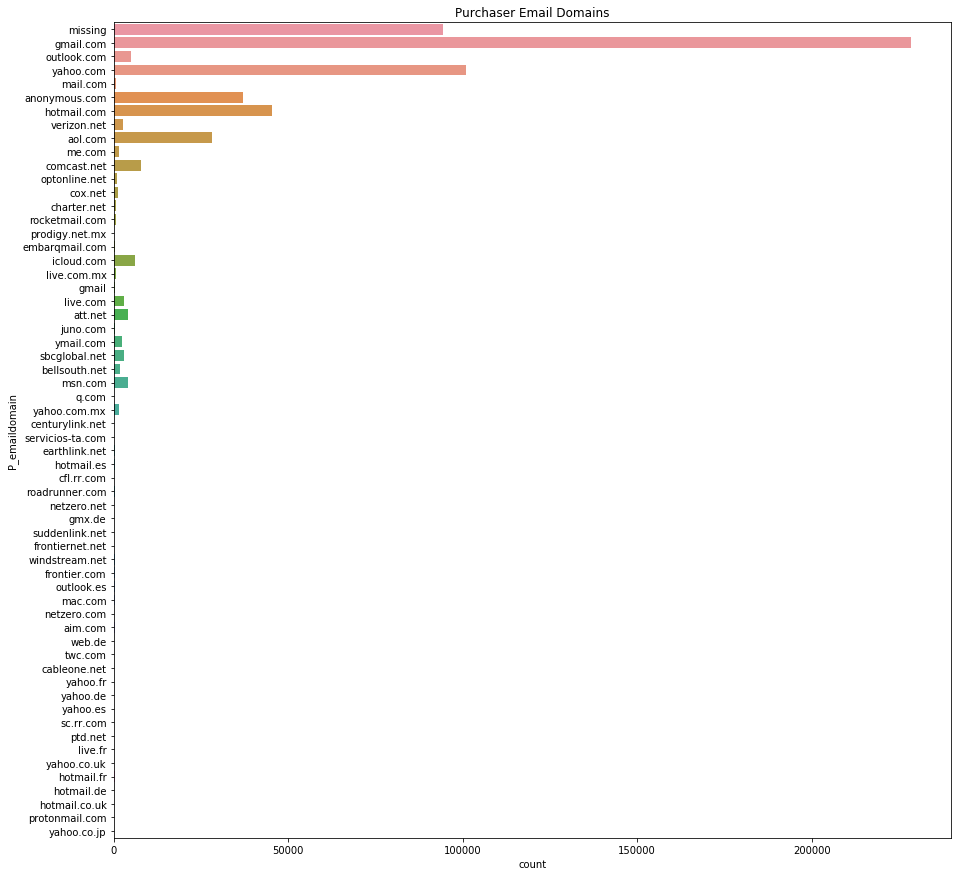

In [49]:
plt.figure(figsize=(15,15))
sns.countplot(y=df_train['P_emaildomain'])
plt.title('Purchaser Email Domains')

In [50]:
# de-dupe values such as gmail.com and gmail:
df_train['P_emaildomain']= df_train['P_emaildomain'].replace(
    regex='gmail.*',value='gmail').replace(
    regex='yahoo.*',value='yahoo').replace(
    regex='hotmail.*',value='hotmail')

In [51]:
# create "other category":
df_train.loc[~df_train.P_emaildomain.isin(
    ['gmail','yahoo','missing','hotmail','anonymous.com'])
             ,'P_emaildomain'] = 'other'

In [52]:
df_train.rename(columns={'P_emaildomain': 'email'}, inplace=True)

Text(0.5, 1.0, 'Purchaser Email Address Domain wrt "isFraud"')

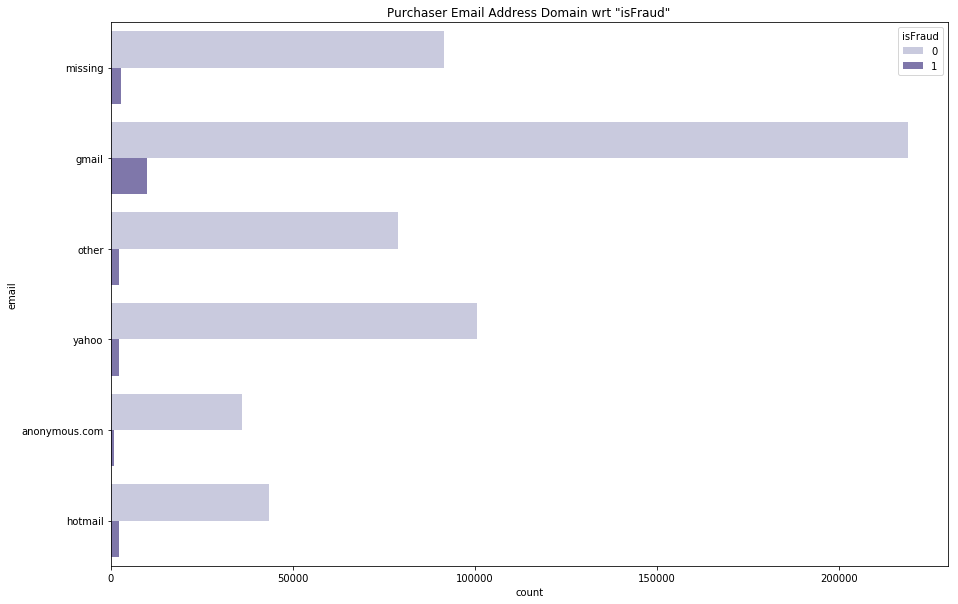

In [53]:
plt.figure(figsize=(15,10))
sns.countplot(y=df_train['email'], hue=df_train['isFraud'], palette='Purples')
plt.title('Purchaser Email Address Domain wrt "isFraud"')

In [54]:
count_table = pd.crosstab(df_train['email'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table))

Power_divergenceResult(statistic=array([229066.4913534 ,  15408.58563616]), pvalue=array([0., 0.]))


In [55]:
# label encode the original variable:
df_train['R_emaildomain'] = encode.fit_transform(df_train['R_emaildomain'])

### Recipient Email Domain

Over 75% of missing values in reciepient email domain. We may drop the variable.

In [56]:
df_train['email'] = encode.fit_transform(df_train['email'])

In [57]:
#df_train['R_emaildomain'].value_counts()

## C1-C14 - "Vesta engineered features"

"C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked."

In [59]:
# for i in df_train.columns:
#     if re.findall(r'^C\d', i):
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

C1-C14 are continous variables, there are no missing values.

## D1-D15

"timedelta, such as days between previous transaction, etc."

In [62]:
# for i in df_train.columns:
#     if re.findall(r'^D\d', i):
# #        print(i)        
#          print('Unique values in column {} are: {}'
#            .format(i, df_train[i].unique()))

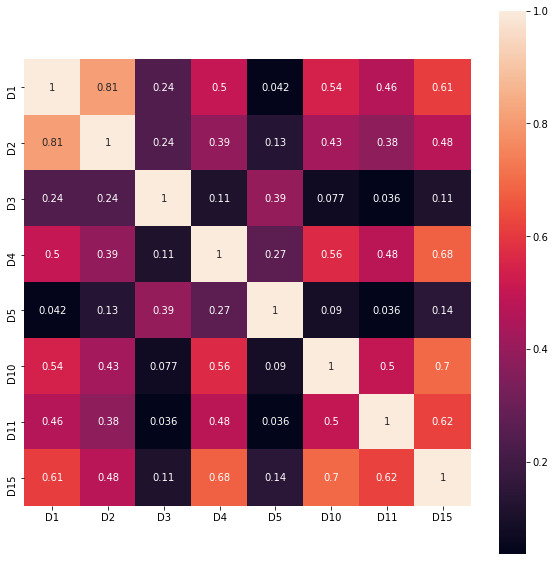

In [63]:
d_df = df_train.filter(regex=('^D\d'))

plt.figure(figsize=(10,10))
D_check_corr = d_df.corr()
sns.heatmap(D_check_corr, annot=True, square=True)

## M1-M9
"match, such as names on card and address, etc."

In [64]:
for i in df_train.columns:
    if re.findall(r'^M\d', i):
       # print(i)        
        print('Unique values in column {} are: {}'
          .format(i, df_train[i].unique()))

Unique values in column M1 are: ['T' 'missing' 'F']
Unique values in column M2 are: ['T' 'missing' 'F']
Unique values in column M3 are: ['T' 'missing' 'F']
Unique values in column M4 are: ['M2' 'M0' 'missing' 'M1']
Unique values in column M5 are: ['F' 'T' 'missing']
Unique values in column M6 are: ['T' 'F' 'missing']
Unique values in column M7 are: ['missing' 'F' 'T']
Unique values in column M8 are: ['missing' 'F' 'T']
Unique values in column M9 are: ['missing' 'F' 'T']


In [65]:
for i in df_train.columns:
    if re.findall(r'^M\d', i):
        df_train[i] = encode.fit_transform(df_train[i])

Note: originally, these variables were missing almost 50% of values.

## Vxxx

"Vesta engineered rich features, including ranking, counting, and other entity relations."

In [66]:
v_df = df_train.filter(regex=('^V\d'))
v_df.shape

(590540, 292)

There are 292 remaining Vxxx variables. We'll perform PCA for dimensionality reduction.

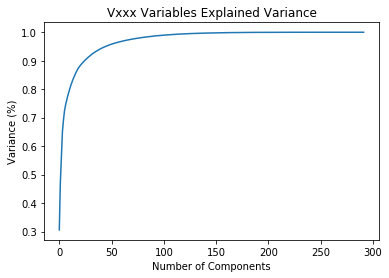

In [67]:
# standartize data:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(v_df)
pca = PCA().fit(data_rescaled)

# plot explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Vxxx Variables Explained Variance')
plt.show()

In [68]:
# perform PCA, add new features to the dataframe:
pca = PCA(n_components=25)
C_pca = pca.fit_transform(data_rescaled)
principalDf = pd.DataFrame(data = C_pca)

df_train = pd.concat([df_train, principalDf], axis = 1)
df_train = df_train.drop(df_train.filter(regex=('^V\d')),axis=1)

In [69]:
del v_df,principalDf

### id_
Identity File Variables 

"Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners."

In [70]:
# for i in df_train.columns:
#     if i.startswith('id_'):
#         #print(i)
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

In [71]:
for i in df_train.columns:
    if df_train[i].dtype==object:
        if i.startswith('id_'):
            df_train[i] = encode.fit_transform(df_train[i])

id variables had a lot of missing values that we've imputed. We may drop these depending on model.

### DeviceType and DeviceInfo

In [72]:
df_train['DeviceType'].value_counts()

missing    449730
desktop     85165
mobile      55645
Name: DeviceType, dtype: int64

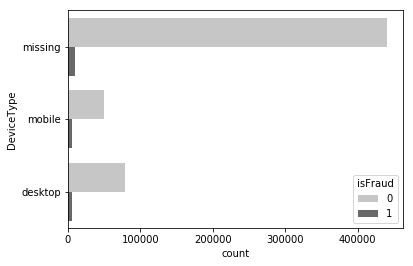

In [73]:
sns.countplot(y=df_train['DeviceType'], hue=df_train['isFraud'], palette='Greys')

In [74]:
count_table = pd.crosstab(df_train['DeviceType'],df_train['isFraud'])
count_table

isFraud,0,1
DeviceType,,
desktop,79611,5554
missing,440278,9452
mobile,49988,5657


In [75]:
# use label encoding to prepare data for tree-based models:
df_train['DeviceType'] = encode.fit_transform(df_train['DeviceType'])

In [76]:
df_train['DeviceInfo'] = encode.fit_transform(df_train['DeviceInfo'])

In [77]:
df_train.shape

(590540, 92)

In [78]:
# # verify there are no mo missing values:
# df_train.isnull().sum()

In [79]:
# verify there are only numeric variables:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 92 columns):
isFraud           590540 non-null int64
TransactionDT     590540 non-null int64
TransactionAmt    590540 non-null float64
ProductCD         590540 non-null int64
card1             590540 non-null int64
card2             590540 non-null float64
card3             590540 non-null float64
card4             590540 non-null int64
card5             590540 non-null float64
card6             590540 non-null int64
addr1             590540 non-null float64
addr2             590540 non-null float64
dist1             590540 non-null float64
email             590540 non-null int64
R_emaildomain     590540 non-null int64
C1                590540 non-null float64
C2                590540 non-null float64
C3                590540 non-null float64
C4                590540 non-null float64
C5                590540 non-null float64
C6                590540 non-null float64
C7                59054

In [80]:
df_train.to_csv('clean_data.csv')

## Model Preparation Summary:

We dropped variables with 80% of missing data. We then reviewed variables and addressed missing values and outliers. We transformed variables to numeric and performed PCA to reduce dimensionality. 

We started with 434 variables and currently have 92 features. When working on Random Forest models, we'll adjust the number of features based on feature importance. We will also work with undersampling and oversampling techniques to address class imbalance.